In [1]:
%%time
# Imports
from utils import *

CPU times: total: 1.44 s
Wall time: 4.24 s


In [2]:
%%time

# Get start time
start = time.perf_counter()

# File-Reading
path = os.path.join(os.getcwd() , out_file) # from utils
# user = []
ts = []
# ca = []
tweets = []
# mentions = []
coord = []
# country = []

with open(path , 'r' , encoding='utf-8') as in_file:
    csv_reader = csv.reader(in_file , delimiter = "|")
    for line in csv_reader:
        # user.append(line[0])
        ts.append(line[1])
        # ca.append(line[2])
        tweets.append(line[3])
        # mentions.append(line[4])
        coord.append(line[5])
        # country.append(line[6])

CPU times: total: 297 ms
Wall time: 298 ms


1. Select countries - keep Ukraine?
2. Isolation forest - identify high-volume days // Bollinger bands
3. Characterize with word clouds / another method

In [3]:
%%time

# Make DF
twt_coord_df_0 = pd.DataFrame(
    list(zip( tweets , coord)) , 
    columns = ['tweet_id' , 'coord']
)

twt_coord_df_0 = twt_coord_df_0[twt_coord_df_0['tweet_id']!= "None"].drop_duplicates()
print(f'length is {len(twt_coord_df_0)}')
twt_coord_df_0 = twt_coord_df_0[twt_coord_df_0['coord']!= "None"].drop_duplicates()
print(f'length after removing blank coord is {len(twt_coord_df_0)}')

length is 155478
length after removing blank coord is 8698
CPU times: total: 234 ms
Wall time: 211 ms


In [34]:
# Restrict Coords
long_max = 0.3
long_min = -0.5
lat_max = 51.6
lat_min = 51.3
twt_coord_df = to_coord(twt_coord_df_0 , ['coord'])

# Constrict to an area over London
twt_coord_df = twt_coord_df[
    (twt_coord_df['coord_long']>=long_min)&(twt_coord_df['coord_long']<=long_max)&
    (twt_coord_df['coord_lat']>=lat_min)&(twt_coord_df['coord_lat']<=lat_max)
]
x_coord = twt_coord_df['coord_long']
y_coord = twt_coord_df['coord_lat']

In [22]:
shape_file = os.path.join(os.getcwd() , 'Green spaces London\\Green spaces London\\Green_spaces.shp')

patches_greenery = []

with fiona.open(shape_file) as layers:
    for feature in layers:
        p = shape(feature['geometry'])
        try:
            # idk..something weird is happening with the lats and longs - some sort of switch. swapped them for now
            lons , lats = np.array(p.exterior.coords.xy)
            lons_and_lats = list(zip(lons, lats))
            wgs84_coord = []
            for lon_and_lat in lons_and_lats:
                wgs84_coord.append(OSGB36toWGS84(lon_and_lat[0] , lon_and_lat[1])[::-1])
            patches_greenery.append(PolygonPatch(wgs84_coord , closed = False))
        except AttributeError:
            for poly in p.geoms:
                # idk..something weird is happening with the lats and longs - some sort of switch. swapped them for now
                lons , lats = np.array(poly.exterior.coords.xy)
                lons_and_lats = list(zip(lons, lats))
                wgs84_coord = []
                for lon_and_lat in lons_and_lats:
                    wgs84_coord.append(OSGB36toWGS84(lon_and_lat[0] , lon_and_lat[1])[::-1])
                patches_greenery.append(PolygonPatch(wgs84_coord , closed = False))

In [23]:
# shape_file = os.path.join(os.getcwd() , 'groads-v1-europe-shp\\groads-v1-europe-shp')

# patches = []

# with fiona.open(shape_file) as layers:
#     for feature in layers:
#         p = shape(feature['geometry'])
#         try:
#             lons , lats = np.array(p.xy)
#             lons_and_lats = list(zip(lons, lats))
#             patches.append(PolygonPatch(lons_and_lats , closed = False))
#         except NotImplementedError:
#             for poly in p.geoms:
#                 lons , lats = np.array(poly.xy)
#                 lons_and_lats = list(zip(lons, lats))
#                 patches.append(PolygonPatch(lons_and_lats , closed = False))

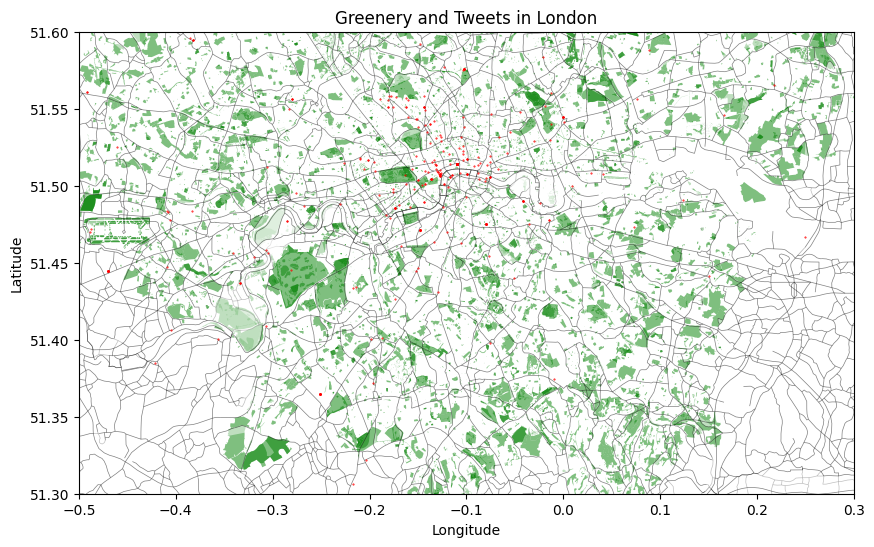

In [35]:
# Make subplot
fig , ax = plt.subplots(figsize = (10,6))

p1 = PatchCollection(patches_greenery , edgecolor = 'green' , lw = 0.01 , facecolor = 'green', alpha  = 0.5);
ax.add_collection(p1);

p2 = PatchCollection(patches , edgecolor = 'k' , lw = 0.5 , facecolor = 'white', alpha =0.5);
ax.add_collection(p2);

# Scatter for tweets
# ax1 = ax.hexbin(x_coord , y_coord , gridsize = 200 , bins = 'log' , cmap = "Reds");
ax.scatter(x_coord, y_coord,s=0.2,c='red')
cbar = fig.colorbar(ax1);
cbar.set_label('Number of Tweets');

plt.xlabel('Longitude');
plt.ylabel('Latitude');
plt.autoscale();
plt.title('Greenery and Tweets in London')
plt.xlim(long_min,long_max);
plt.ylim(lat_min,lat_max);

### JUNK

In [ ]:
# %%time
# # Euro Road Layout - 2min31.7sec
# shape_file = os.path.join(os.getcwd() , 'opgrsp_essh_gb\\OS Open Greenspace (ESRI Shape File) GB\\data\\GB_GreenspaceSite.shp')

# data = {}
# patches = []

# with fiona.open(shape_file) as layers:
#     for feature in layers:
#         p = shape(feature['geometry'])
#         try:
#             # idk..something weird is happening with the lats and longs - some sort of switch. swapped them for now
#             lons , lats = np.array(p.exterior.coords.xy)
#             lats_and_lons = list(zip(lats, lons))
#             wgs84_coord = []
#             for lon_and_lat in lons_and_lats:
#                 wgs84_coord.append(OSGB36toWGS84(lon_and_lat[1] , lon_and_lat[0]))
#             patches.append(PolygonPatch(wgs84_coord , closed = False))
#         except AttributeError:
#             for poly in p.geoms:
#                 # idk..something weird is happening with the lats and longs - some sort of switch. swapped them for now
#                 lons , lats = np.array(poly.exterior.coords.xy)
#                 wgs84_coord = []
#                 for lon_and_lat in lons_and_lats:
#                     wgs84_coord.append(OSGB36toWGS84(lon_and_lat[1] , lon_and_lat[0]))
#                 patches.append(PolygonPatch(wgs84_coord , closed = False))

In [ ]:
# World Map Boundaries
data = {}
pops = {}

# https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/nuts
shape_file = os.path.join(os.getcwd() , 'world_map\\TM_WORLD_BORDERS_SIMPL-0.3.shp')

with fiona.open(shape_file) as layer:
    for feature in layer:
        country_code = feature['properties']['NAME']
        data[country_code] = shape(feature['geometry'])

patches = []
colours = []

for c in data:
    try:
        for p in data[c].geoms:
            lons , lats = np.array(p.exterior.coords.xy)
            patches.append(PolygonPatch(list(zip(lons , lats)) , closed = True))
            
    except AttributeError:
        lons , lats = np.array(data[c].exterior.coords.xy)
        patches.append(PolygonPatch(list(zip(lons , lats)) , closed = True))
        
# Euro Population Density
shape_file = os.path.join(os.getcwd() , 'europe-places-shape\\places.shp')

data = {}
pop = {}

with fiona.open(shape_file) as layers:
    for feature in layers:
        name = feature['properties']['name']
        data[name] = shape(feature['geometry'])
        pop[name] = feature['properties']['population']

name = []
lats = []
longs = []
colours = []

for place in data:
    name.append(place)
    longs.append(data[place].x)
    lats.append(data[place].y)
    colours.append(pop[place])
        
# Population
place_df_0 = pd.DataFrame(
    list(zip(name, longs, lats, colours)) ,
    columns = ['place', 'longitude', 'latitude', 'population']
)

# place_df = place_df_0[place_df_0['population']>0].copy()
# place_df['population'] = place_df['population'].apply(lambda x : np.log10(x))

fig , ax = plt.subplots()

# Overlay map
p = PatchCollection(patches , edgecolor = 'k' , lw = 1.5 , facecolor = 'white' , alpha = 0.4);
ax.add_collection(p);
ax.scatter(place_df.longitude , place_df.latitude , c = place_df.population , cmap = 'RdYlGn' , s = 0.002);

# Plot Characteristics
plt.title('Population Density over Europe');
plt.xlim(-30 , 65);
plt.ylim(30 , 72);
plt.grid();
plt.show()

In [31]:
# %%time

# # Euro Road Layout - 2min31.7sec
# shape_file = os.path.join(os.getcwd() , 'europe-roads-shape\\roads.shp')

# data = {}
# patches_roads = []

# with fiona.open(shape_file) as layers:
#     for feature in layers:
#         id = feature['properties']['osm_id']
#         data[id] = shape(feature['geometry']).xy

for id in data:
    x , y = data[id]
    patches_roads.append(PolygonPatch(list(zip(lons , lats)) , closed = True))

KeyboardInterrupt: 

In [33]:
len(data) , len(patches_roads)

(7959588, 5261322)

In [37]:
with open('data_road.pkl' , 'wb') as h:
    pickle.dump(data , h)

with open('patches_road.pkl' , 'wb') as h:
    pickle.dump(patches_roads , h)

KeyboardInterrupt: 

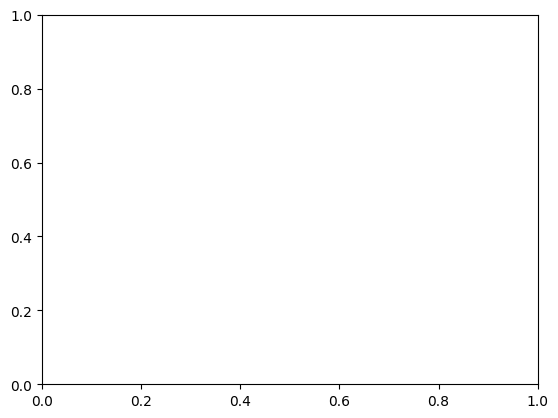

In [34]:
fig , ax = plt.subplots()

# Overlay map
p = PatchCollection(patches_roads , edgecolor = 'red' , lw = 1.5 , facecolor = 'black' , alpha = 0.4);
ax.add_collection(p);

ax.autoscale();

In [30]:
len(patches_roads)

1169119

In [107]:
# Euro Road Layout - 2min31.7sec
shape_file = os.path.join(os.getcwd() , 'europe-roads-shape\\roads.shp')

patches_roads = []
k = 0
with fiona.open(shape_file) as layers:
    for feature in layers:
        # lons , lats = np.array(shape(feature['geometry']).xy)
        # patches_roads.append(PolygonPatch(list(zip(lons , lats)) , closed = False))
        k += 1

In [108]:
# ex 4

from fastkml import kml
from shapely.geometry import Polygon

with open("C:\\Users\\soura\\Documents\\ECMM443\\17.11.22\\Local_Authority_Districts_(December_2015)_Boundaries.kml" , encoding='utf-8') as my_file:
    doc = my_file.read()
k = kml.KML()
k.from_string(doc)

document = list(k.features())
folder = list(document[0].features())
places = list(folder[0].features())

code_to_name = {}
for p in places:
    poly = p.geometry;
    for d in p.extended_data.elements[0].data:
        if d['name'] == 'lad15cd':
            id_code = d['value']
        if d['name'] == 'lad15nm':
            name = d['value']
    code_to_name[id_code] = poly

patches = []

for c in code_to_name:
    try:
        for pol in code_to_name[c].geoms:
            lons , lats = np.array(pol.exterior.coords.xy)
            patches.append(PolygonPatch(list(zip(lons , lats)) , closed = True))

    except AttributeError:
        lons , lats = np.array(code_to_name[c].exterior.coords.xy)
        patches.append(PolygonPatch(list(zip(lons , lats)) , closed = True))

# Make subplot
fig , ax = plt.subplots(figsize = (10,5))

# Overlay map
patch_col = PatchCollection(patches , edgecolor = 'white' , lw = 0.5 , facecolor = 'black');
ax.add_collection(patch_col);

# Scatter for tweets
ax1 = ax.hexbin(x_coord , y_coord , gridsize = 300 , bins = 'log' , cmap = "viridis");
cbar = fig.colorbar(ax1);
cbar.set_label('Number of Tweets');

ax.autoscale();
ax.grid();
ax.set_xlabel('Longitude');
ax.set_ylabel('Latitude');
plt.xlim(long_min,long_max);
plt.ylim(lat_min,lat_max);

7959588

In [ ]:
%%time
# Euro Road Layout - 2min31.7sec
shape_file = os.path.join(os.getcwd() , 'opgrsp_essh_gb\\OS Open Greenspace (ESRI Shape File) GB\\data\\GB_GreenspaceSite.shp')

patches_greenery = []

with fiona.open(shape_file) as layers:
    for feature in layers:
        p = shape(feature['geometry'])
        try:
            # idk..something weird is happening with the lats and longs - some sort of switch. swapped them for now
            lons , lats = np.array(p.exterior.coords.xy)
            lons_and_lats = list(zip(lons, lats))
            wgs84_coord = []
            for lon_and_lat in lons_and_lats:
                wgs84_coord.append(OSGB36toWGS84(lon_and_lat[0] , lon_and_lat[1])[::-1])
            patches_greenery.append(PolygonPatch(wgs84_coord , closed = False))
        except AttributeError:
            for poly in p.geoms:
                # idk..something weird is happening with the lats and longs - some sort of switch. swapped them for now
                lons , lats = np.array(poly.exterior.coords.xy)
                lons_and_lats = list(zip(lons, lats))
                wgs84_coord = []
                for lon_and_lat in lons_and_lats:
                    wgs84_coord.append(OSGB36toWGS84(lon_and_lat[0] , lon_and_lat[1])[::-1])
                patches_greenery.append(PolygonPatch(wgs84_coord , closed = False))
%%time
# Make subplot
fig , ax = plt.subplots(figsize = (10,7))

# Overlay map
p = PatchCollection(patches_greenery , edgecolor = 'green' , lw = 0.4 , facecolor = 'green');
ax.add_collection(p);

# Scatter for tweets
ax1 = ax.hexbin(x_coord , y_coord , gridsize = 300 , bins = 'log' , cmap = "Reds" , alpha = .9);
cbar = fig.colorbar(ax1);
cbar.set_label('Number of Tweets');

ax.set_xlabel('Longitude');
ax.set_ylabel('Latitude');

# Plot Characteristics
plt.title('Greenery Density over London');
plt.xlim(long_min,long_max);
plt.ylim(lat_min,lat_max);
plt.show()

In [ ]:
from utils import *

base_path = os.path.join(os.getcwd() , 'oproad_essh_gb\\data')
path_list = [os.path.join(base_path , file_name) for file_name in os.listdir(base_path)]
shape_files = [file_name for file_name in path_list if 'shp' in file_name]

In [ ]:
# Make subplot
fig , ax = plt.subplots(figsize = (10,7))

for patch in patches:
    # Overlay map
    p = PatchCollection(patch , edgecolor = 'k' , lw = 0.4 , facecolor = 'white');
    ax.add_collection(p);

plt.xlabel('Longitude');
plt.ylabel('Latitude');
plt.autoscale();